<a href="https://colab.research.google.com/github/karnabrajesh/Learning/blob/master/ExploratoryAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re

In [2]:
def load_tweets():
    return pd.read_csv('/content/sample_data/trump_tweets.csv')

**Load tweets and check for devices with most tweets**

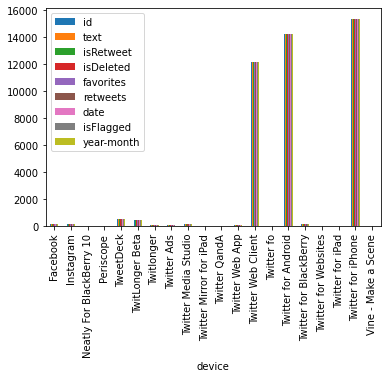

In [6]:
tweet_df = load_tweets()
tweet_df['year-month'] = pd.to_datetime(tweet_df['date']).dt.strftime('%Y-%m')
group_df = tweet_df.groupby('device')
group_df.count().plot.bar()

In [8]:
twitter_for_iPhone_df = group_df.get_group('Twitter for iPhone').set_index(['date']).sort_index()
twitter_web_client_df = group_df.get_group('Twitter Web Client').set_index(['date']).sort_index()
twitter_for_android_df = group_df.get_group('Twitter for Android').set_index(['date']).sort_index()

Getting tweets for as sort with date. Then group by year-month and combine text:
 - Web Client
 - Android
 - iphone

In [9]:
iphone_grouped = twitter_for_iPhone_df.groupby('year-month').agg({'text':'sum'})
android_grouped = twitter_for_android_df.groupby('year-month').agg({'text':'sum'})
web_grouped = twitter_web_client_df.groupby('year-month').agg({'text':'sum'})

In [11]:
iphone_sentiment = []
android_sentiment = []
web_sentiment = []

Using https://pypi.org/project/vaderSentiment/ for sentiment analyzer

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


In [15]:
#For iphone, android, and web

for index, t in iphone_grouped.iterrows():
  ps = analyzer.polarity_scores(t['text'])
  iphone_sentiment.append({'date':index,'compound':ps['compound']})

for index, t in android_grouped.iterrows():
  ps = analyzer.polarity_scores(t['text'])
  android_sentiment.append({'date':index,'compound':ps['compound']})

for index, t in web_grouped.iterrows():
  ps = analyzer.polarity_scores(t['text'])
  web_sentiment.append({'date':index,'compound':ps['compound']})

In [16]:
iphone_senti_df = pd.DataFrame(iphone_sentiment)
iphone_senti_df['date'] = pd.to_datetime(iphone_senti_df['date']).dt.strftime('%Y')

android_sentiment_df = pd.DataFrame(android_sentiment)
android_sentiment_df['date'] = pd.to_datetime(android_sentiment_df['date']).dt.strftime('%Y')

web_sentiment_df = pd.DataFrame(web_sentiment)
web_sentiment_df['date'] = pd.to_datetime(web_sentiment_df['date']).dt.strftime('%Y')

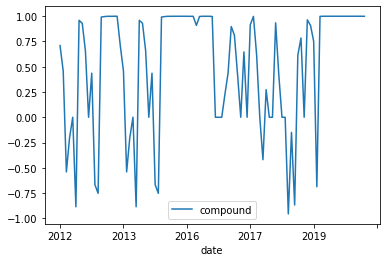

In [30]:
iphone_senti_df.index = iphone_senti_df['date']
iphone_senti_df.plot.line()

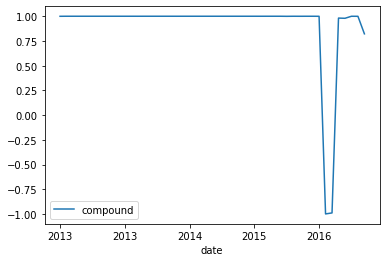

In [31]:
android_sentiment_df.index = android_sentiment_df['date']
android_sentiment_df.plot.line()

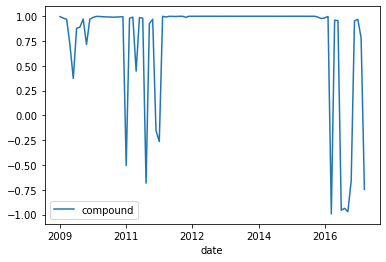

In [32]:
web_sentiment_df.index = web_sentiment_df['date']
web_sentiment_df.plot.line()

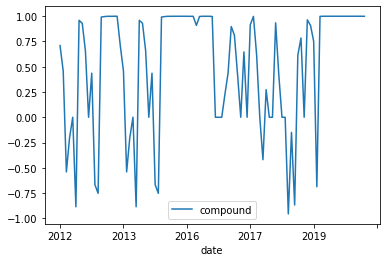

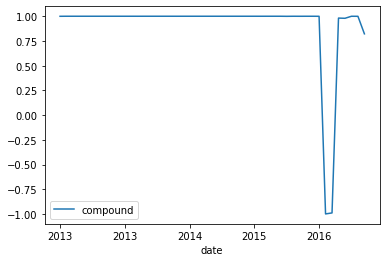

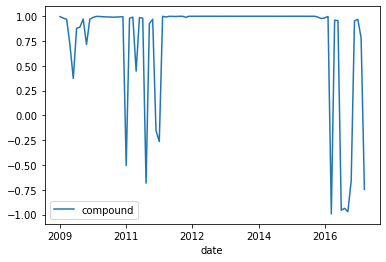

In [34]:
iphone_senti_df.plot.line()
android_sentiment_df.plot.line()
web_sentiment_df.plot.line()